##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [365]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
import datetime
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

%matplotlib notebook

# %matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass



from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


# FirstRun = True
# FirstRun = False
aliases={'wind_speed':'$\overline{U}$','PPFD_Avg':'PPFD','fco2':'fco2',
        'Out_of_Basin':'OOB',#'F$_{out}$',
        'Upland':'Upland',#'F$_{up}$',
        'Sedge':'Sedge',#'F$_{sdg}$',
        'Shrub':'Shrub',#'F$_{shb}$',
        'Sparse':'Sparse',#'F$_{spr}$',
        'Grass':'Grass',#'F$_{grs}$',
        'Temp':'T$_{s}$','H':'$H$','VPD':'VPD','VWC':'$VWC$',
        'Water Table': 'W$_{TBL}$','Active Layer':'AL',
        'AirTC_Avg':'T$_{a}$','air_pressure':'P$_{a}$',
        'Wind Spd':'$\overline{U}$','24H Rain':'24HR','Wtr Tbl Trnd':'d Wtr Tbl',
        'air pressure':'P$_{a}$','Ta':'T$_{a}$','Rn':'Rn','PPFD':'PPFD','Rain':'Rain',
        'Ts 2.5 cm':'T$_{2.5cm}$','Ts 15 cm':'T$_{15cm}$','(z-d)/L':'Stability'}

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
Site='Illisarvik'

In [218]:
class ResultMap:
    def __init__(self,target,Test='T',SE_Rule=1,alpha = .025):
        self.SE_Rule = SE_Rule
        self.target = target
        self.target_name = target
        if target == 'fco2_Final' or target == 'ER':
            self.target = 'fco2'
            self.target_name = 'ER'
        if target == 'fch4_Final':
            self.target = 'fch4'
            self.target_name = 'fch4'
        self.params = Dense.Params('Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,'ECData.csv')#,resample='2H')
        self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Number'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Records['SE']
        Names = []
        rem = []
        for level in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==level]
#             print(Level)
            if level == 1:
                level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                LastMod=[level_best['Model'].values[0]]
                Names.append(aliases[LastMod[0]])
            elif level == 99:
                level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                LastMod=[level_best['Model'].values[0]]
                Names.append('N/A')
            else:
                level_best = level_best.append(Level.loc[Level['MSE']==Level['MSE'].min()])
                Mod = level_best.loc[level_best['Size']==level,'Model'].values[0].split('+')

        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        self.level_best = level_best
        
        self.Records['T2']=0
        self.Records['Performance'] = 0
        for j in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==j]
#             Level.loc[Level['MSE'] == Level['MSE'].min(),'Performance']=1
            ##T-test
            if Test == 'T':
                Sv = (((Level['SE']**2+self.Min['SE'].values[0]**2)/2)**.5)
                Level['T2']=(Level['MSE']-self.Min['MSE'].values[0])/(Sv*(2/self.params['K'])**.5)
#                 print(-stats.t.ppf(1-alpha,self.params['K'])
                Level.loc[Level['T2'].abs()<=stats.t.ppf(1-alpha,self.params['K']),'Performance']+=1
#                 print(Level[['Model','T2']])
            ##SE-Rule
            else:
                Test == 'SE'
                Level.loc[Level['MSE']<=self.Min['MSE'].values[0]+self.Min['SE'].values[0]*SE_Rule,'Performance']+=1
            self.Records.loc[self.Records['Size']==j]=Level
        
            Trecords = self.Records.loc[self.Records['Performance']==self.Records['Performance'].max()]
            self.Best = (Trecords.loc[Trecords['Size']==Trecords['Size'].min()])
            self.Model_Selection = self.Best.loc[self.Best['MSE'] == self.Best['MSE'].min(), 'Model'].values[0]
                
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
#         idx = '99_99'
        self.params['Spath']=(self.params['Dpath']+'/'+self.target_name+'/'+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
        display(prog1)
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
#             for k in range(self.params['K']):
#                 results=Dense.Load_Model(k,X=X,params=self.params)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.params['K']))):
                prog1.value+=1
                Y = results
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
        
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
#         plt.figure()
        YTru = self.RST.y+0.0
#         plt.scatter(Y_fill_bar,self.RST.y)
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        pool = Pool(processes=1,maxtasksperchild=75)
        
        YVar = Dense.Load_Model(i=1,X=X,params=self.params)
#             YVar = results
        YVar = self.RST.YvarScaled.inverse_transform(YVar) 
        for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(1,2))):
            YVar = results
            YVar = self.RST.YvarScaled.inverse_transform(YVar)                    
        pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        
#         print(X_back)
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            print(self.Data_Map.shape,self.RST.Data['key'].shape)
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        
#         if Imputate == True:
        self.Y_fill = Y_fill
     

In [219]:
def Performance(ax,title,target,verbose):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
           yerr=target.level_best['SE'].values*target.SE_Rule,
           color='grey',
        alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.SE_Rule,
           color='red',
           alpha = 1,
           label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.SE_Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
#     ax.set_ylabel('MSE')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.SE_Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.SE_Rule])
    plt.sca(ax)
    plt.grid()
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    if verbose>1:
        print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,SE_Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.SE_Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.SE_Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.SE_Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
        print(Best)
    else:
        alpha = .025
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.SE_Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.SE_Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.SE_Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
#         print(Best)
        print()
        print(Data)
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
#         print()
    ax.grid()

def Mapper(AllData,target,target_name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],
                       target.params['Inputs'],
                       ScalePath=target.params['Spath'],
                       Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],
                   target.params['Inputs'],
                   ScalePath=target.params['Spath'],
                   Project=True,
                   fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[target_name] = target.Data_Map[target.target].values
    AllData[target_name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[target_name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[target_name+'_CI'] = target.Data_Map['CI'].values
    AllData[target_name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

def PooledVar_interval(Data,Vars,mean,n): #Pooledstd_interval
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
#     print(Ux)
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
#     print(SigmaX)
    return(SigmaX)

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


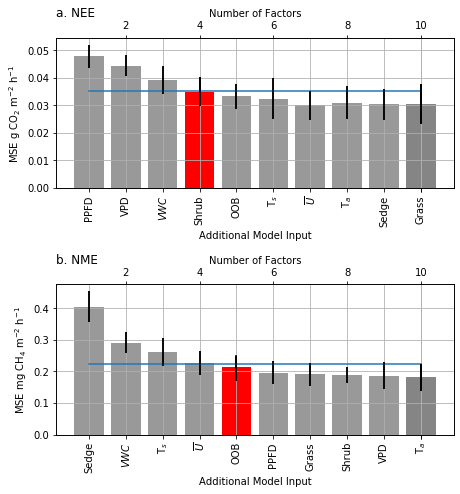

In [350]:

fco2 = ResultMap('fco2',Test='SE',SE_Rule=1)
fch4 = ResultMap('fch4',Test='SE',SE_Rule=1)
ER = ResultMap('ER')
ER.Model_Selection=ER.Records['Model'].values[0]
fco2_fixed = ResultMap('fco2',Test='SE',SE_Rule=1)
fch4_fixed = ResultMap('fch4',Test='SE',SE_Rule=1)
ER_fixed = ResultMap('ER')
ER_fixed.Model_Selection=ER_fixed.Records['Model'].values[0]
PAR = ResultMap('fco2',Test='SE')
PAR.Model_Selection='PPFD'
Sedge = ResultMap('fch4',Test='SE')
Sedge.Model_Selection='Sedge'


fig,ax=plt.subplots(2,1,figsize=(6.5,7))
Performance(ax[0],'a. NEE',fco2,verbose = 0)
Performance(ax[1],'b. NME',fch4,verbose = 0)
ax[0].set_ylabel('MSE g CO$_2$ m$^{-2}$ h$^{-1}$')
ax[1].set_ylabel('MSE mg CH$_4$ m$^{-2}$ h$^{-1}$')

plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Appendix1.png',dpi=300)

<IPython.core.display.Javascript object>


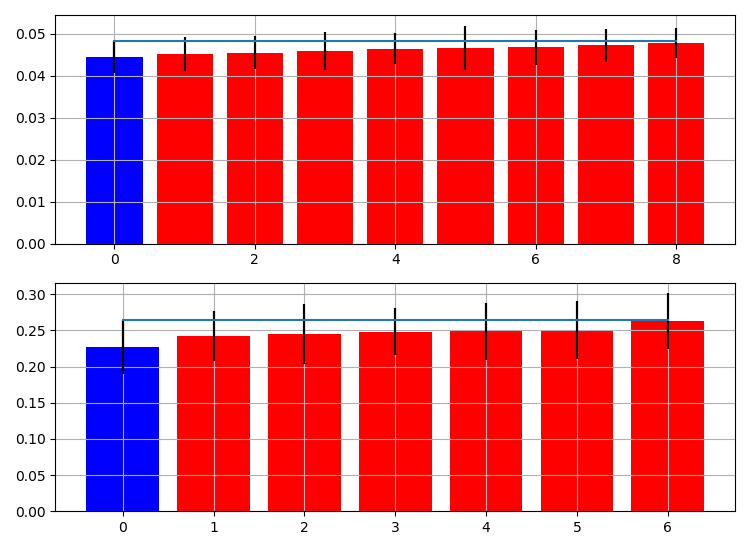


   index                  Model       MSE  Size  Number        SE  \
0      3           PPFD_Avg+VPD  0.044475     2       2  0.003730   
1      1    wind_speed+PPFD_Avg  0.045157     2       0  0.004076   
2      5           PPFD_Avg+VWC  0.045546     2       4  0.004027   
3      9  PPFD_Avg+Out_of_Basin  0.045961     2       8  0.004551   
4      7         PPFD_Avg+Shrub  0.046423     2       6  0.003695   
5      6         PPFD_Avg+Sedge  0.046691     2       5  0.005199   
6      2     PPFD_Avg+AirTC_Avg  0.046765     2       1  0.004227   
7      4          PPFD_Avg+Temp  0.047258     2       3  0.003856   
8      8         PPFD_Avg+Grass  0.047836     2       7  0.003626   

   Performance Model_Key      RMSE  T2  
0            0       2_2  0.210891   0  
1            0       2_0  0.212502   0  
2            0       2_4  0.213416   0  
3            0       2_8  0.214385   0  
4            0       2_6  0.215460   0  
5            0       2_5  0.216080   0  
6            0       

In [453]:
fig,ax=plt.subplots(2,1,figsize=(7.5,5.5))
LevelPerformance(ax[0],'a. fco2',fco2,level=2)
LevelPerformance(ax[1],'b. fch4',fch4,level=4)
plt.tight_layout()

In [352]:
T30 = ER.RST.Master.loc[ER.RST.Master['fco2']>0]
T30 = fco2.RST.Master.copy()
T30['VWC'].loc[T30['VWC']<.5]=np.nan
T30['VWC']=T30['VWC'].interpolate()

T30['Rain_mm_Tot']=T30['Rain_mm_Tot'].fillna(0)*10
T30[['Sedge','Shrub','Grass','Upland']]=T30[['Sedge','Shrub','Grass','Upland']].interpolate()

T30_Dark = T30.copy()
T30_Fixed = T30.copy()
T30_Dark['PPFD_Avg']=T30['PPFD_Avg'].min()
FPRatios = {'Sedge':.123,
            'Sparse':.084,
            'Shrub':.483,
            'Grass':.279,
            'Upland':0.0,
            'Out_of_Basin':0.0
}
for var in ['Sedge','Sparse','Shrub','Grass','Upland','Out_of_Basin']:
    T30_Fixed[var] = FPRatios[var]
T30_Dark_Fixed = T30_Fixed.copy()
T30_Dark_Fixed['PPFD_Avg']=T30['PPFD_Avg'].min()


T30 = Mapper(T30,fco2,'NEE_est',Fill = False)
print('NEE_est')

T30 = Mapper(T30,fch4,'NME_est',Fill = False)
print('NME_est')

T30 = Mapper(T30,ER,'ER_est',Fill = False,DarkTarget=T30_Dark)
print('ER_est')

for target,name in zip([fch4,fco2,ER],['NME','NEE','ER']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target_name].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target_name].fillna(T30['Fill'])
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')

T30 = Mapper(T30,ER_fixed,'ER_fixed_est',Fill = False,DarkTarget=T30_Dark_Fixed)
print('ER_fixed_est')

T30 = Mapper(T30,fco2_fixed,'NEE_fixed_est',Fill = False,DarkTarget=T30_Fixed)
print('NEE_fixed_est')

T30 = Mapper(T30,fch4_fixed,'NME_fixed_est',Fill = False,DarkTarget=T30_Fixed)
print('NME_fixed_est')

for target,name in zip([fch4_fixed,fco2_fixed,ER_fixed],['NME_fixed','NEE_fixed','ER_fixed']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target_name].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target_name].fillna(T30['Fill'])
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')

# T30 = Mapper(T30,PAR,'PAR_ER_est',Fill = False,DarkTarget=T30_Dark)
# print('PAR_ER_est')

# for target,name in zip([PAR],['PAR_ER']):
#     target.cols = []
#     for i in range(target.Y_fill.shape[0]):
#         T30['Fill']  = target.Y_fill[i,:]
#         B = target.RST.Master[target.target_name].fillna(T30['Fill'])
#         T30[name+'_'+str(i)] = target.RST.Master[target.target_name].fillna(T30['Fill'])
#         target.cols.append(name+'_'+str(i))
#     T30[name] = T30[target.cols].mean(axis=1)
#     sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
#     target.PooledVar = sp
#     target.Mean = T30[name].mean()
# print('Done')

# T30 = Mapper(T30,PAR,'PAR_est',Fill = False)
# print('PAR_est')

# T30 = Mapper(T30,Sedge,'Sedge_est',Fill = False)
# print('Sedge_est')

# for target,name in zip([PAR,Sedge],['PAR','Sedge']):
#     target.cols = []
#     for i in range(target.Y_fill.shape[0]):
#         T30['Fill']  = target.Y_fill[i,:]
#         B = target.RST.Master[target.target_name].fillna(T30['Fill'])
#         T30[name+'_'+str(i)] = target.RST.Master[target.target_name].fillna(T30['Fill'])
#         target.cols.append(name+'_'+str(i))
#     T30[name] = T30[target.cols].mean(axis=1)
#     sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
#     target.PooledVar = sp
#     target.Mean = T30[name].mean()
# print('Done')



C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


FloatProgress(value=0.0, description='Running:', max=30.0)

NEE_est


FloatProgress(value=0.0, description='Running:', max=30.0)

NME_est


FloatProgress(value=0.0, description='Running:', max=30.0)

ER_est
Done


FloatProgress(value=0.0, description='Running:', max=30.0)

ER_fixed_est


FloatProgress(value=0.0, description='Running:', max=30.0)

NEE_fixed_est


FloatProgress(value=0.0, description='Running:', max=30.0)

NME_fixed_est
Done


IndexError: index 0 is out of bounds for axis 0 with size 0

In [337]:
# print(T30[['NEE','fco2']])
# print(T30['ER_est'].head(),T30['NEE'].head())
# print(T30['NEE_est'].mean())

In [353]:
T30['GPP'] = -1*T30['NEE']+T30['ER']
T30['GPP_fixed'] = -1*T30['NEE_fixed']+T30['ER_fixed']


T30 = T30.loc[((T30.index>'2016-07-10 23:30:00') & (T30.index<'2016-08-07 00:00:00'))]
H1 = T30.resample('D').mean()
# v='NEE'

H1['Rain_mm_Tot'] = T30['Rain_mm_Tot'].resample('D').sum()
H1s = T30.resample('D').std()
for v in ['ER_est_','NEE_est_','NME_est_']:#,'NEE_fixed_est_','ER_fixed_est_','NME_fixed_est_']:#,'NEE_JustPPFD_','ER_JustPPFD_']:
    H1[v+'Pooled_CI'] = 0
    for day in H1.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
#         if v
        pooled_std = PooledVar_interval(Samp,[v+'Var_reg',v+'Var_er'],v[:-1],n=2)**.5
        H1.loc[H1.index==day,v+'Pooled_CI']=pooled_std/(Samp.shape[0]**.5)*stats.t.ppf(1-.025,Samp.shape[0])
        H1.loc[H1.index==day,v+'Pooled_PI']=pooled_std*((1/Samp.shape[0]+1/T30.shape[0])**.5)*stats.t.ppf(1-.025,Samp.shape[0])
for target,v in zip([ER,fco2,fch4],['ER','NEE','NME']):
    H1[v+'Pooled_CI'] = 0
    for day in H1.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
#         if v
        pooled_std = PooledVar_interval(Samp,target.cols,v,n=2)**.5
        H1.loc[H1.index==day,v+'Pooled_CI']=pooled_std/(Samp.shape[0]**.5)*stats.t.ppf(1-.025,Samp.shape[0])
        H1.loc[H1.index==day,v+'Pooled_PI']=pooled_std*((1/Samp.shape[0]+1/T30.shape[0])**.5)*stats.t.ppf(1-.025,Samp.shape[0])


H2 = T30.resample('D').sum()

In [354]:
# PooledVar_interval = Pooledstd_interval
mult = 24#1/(1e-6 * 44.0095 *3600)
Estimates = []
CIs = []
IntType = []
Scale = []
Samples = []
Fluxes = []
Type = []
Targets = {'NEE':fco2,
           'ER':ER,
           'NME':fch4,
           'NEE_fixed':fco2_fixed,
           'ER_fixed':ER_fixed,
           'NME_fixed':fch4_fixed}
for Var in ['NEE','NEE_fixed','ER','ER_fixed','NME','NME_fixed']:#,
# for Var in ['NEE','ER_est','NME']:#,
    target = Targets[Var]
#             'NEE_JustPPFD','ER_JustPPFD']:
# Var = 'NEE'
    if Var == 'NEE' or Var == 'NME':
        CIPI = 'CI'
        Fluxes.append(Var)
        print(Fluxes)
        Type.append('EC Obs.')
        pooled_std = PooledVar_interval(T30,target.cols,Var,n=30)
        Int=pooled_std*(1/T30.shape[0])**.5*stats.t.ppf(1-.025,T30[Var].count())*mult
    else:
        Fluxes.append(Var.split('_')[0])
        CIPI = 'PI'
        Type.append('NN est.')
        pooled_std = PooledVar_interval(T30,target.cols,Var,n=30)
        Int=pooled_std*(1/T30.shape[0]+1/T30.shape[0])**.5*stats.t.ppf(1-.025,T30[Var].count())*mult
    print(Var)
    U = T30[Var].mean()*mult

    Estimates.append(U)
    CIs.append(Int)
    if Var.split('_')[-1]=='fixed':
        Scale.append('Basin')
    elif len(Var.split('_'))>1:
        if Var.split('_')[1][0:3] == 'Jus':
            Scale.append(Var.split('_')[1][4:])
        else:
            Scale.append('Footprint')
    else:
        Scale.append('Footprint')
    
    Samples.append(T30[Var].count())
    IntType.append(CIPI)
           
Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
        '95% CI/PI':CIs,'Interval Type':IntType,'N':Samples,
       'Type':Type}
Res = pd.DataFrame(data = Data)
# print(Res)
Cres = pd.read_csv('C:\\Users\\wesle\\Illisarvik_Processing/ScaledChamberFluxes.csv',
                   index_col=[0],delimiter = ',')
                   
# print(Cres)

All = Res.append(Cres).sort_values('Flux').reset_index(drop=True)
# Tem = (All.loc[All['Type'] == 'NN est.'])
Tem = (All.loc[((All['Type'] == 'NN est.')|(All['Type'] == 'EC Obs.'))])
# print(Tem)
CO2=(Tem.loc[Tem['Flux'] == 'NEE','Estimates']).values[0]
CH4=(Tem.loc[Tem['Flux'] == 'NME','Estimates']*28*1e-3).values[0]

print(CO2,CH4,CO2+CH4)

['NEE']
NEE
NEE_fixed
ER
ER_fixed
['NEE', 'NEE', 'ER', 'ER', 'NME']
NME
NME_fixed
-5.668790091146138 0.33760628217617916 -5.331183808969959


In [355]:
# print(ER_fixed.cols)
print(H1[['NEE','GPP','ER','NME']].max()*mult)
print(H1[['NEE','GPP','ER','NME']].min()*mult)
print(T30['GPP'].mean()*24,14.171224+5.668790)
print(All[['Flux','Type','Scale','Estimates','95% CI/PI']])

print('ER %',(14.171224-14.826690)/14.826690)
print('NEM %',(12.057367-17.086510)/17.086510)

NEE     0.370202
GPP    34.812213
ER     22.490928
NME    36.806870
dtype: float64
NEE   -13.186413
GPP    11.447533
ER      9.470939
NME     2.380950
dtype: float64
19.84001450345745 19.840014
  Flux          Type      Scale  Estimates  95% CI/PI
0   ER       NN est.  Footprint  14.171224   0.938761
1   ER       NN est.      Basin  13.662220   0.912311
2   ER  Chamber Obs.  Footprint  14.826690   3.618140
3   ER  Chamber Obs.      Basin  13.601409   3.846433
4  NEE       EC Obs.  Footprint  -5.668790   0.943525
5  NEE       NN est.      Basin  -5.502707   1.331566
6  NME       EC Obs.  Footprint  12.057367   1.046342
7  NME       NN est.      Basin  12.563050   1.447463
8  NME  Chamber Obs.  Footprint  17.086510  11.525820
9  NME  Chamber Obs.      Basin  19.406718  13.525331
ER % -0.044208518556737804
NEM % -0.2943341267467728


In [503]:
print((14.826690-13.601409)/14.826690)

0.08264022516151609


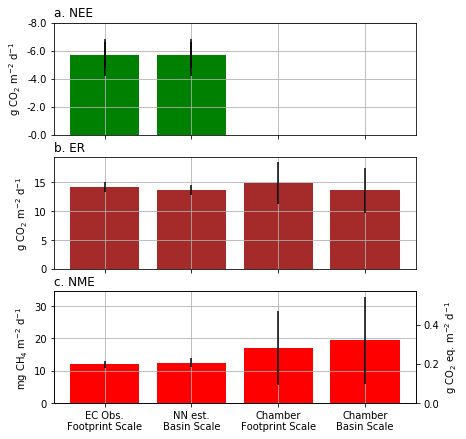

In [356]:
fig,ax = plt.subplots(2,1,figsize = (6.5,7),sharex=True)


ax1 = plt.subplot2grid((3, 1), (0, 0))
ax2 = plt.subplot2grid((3, 1), (1, 0))#, rowspan=2)
ax3 = plt.subplot2grid((3, 1), (2, 0))
Labels =['EC Obs.\nFootprint Scale','NN est.\nBasin Scale','Chamber\nFootprint Scale','Chamber\nBasin Scale']
# ax1.bar([2,3],[0,0],All
#         color='None')
# ax1.bar([0,1],All.loc[All['Flux']=='GPP','Estimates']*-1,color='lightgreen',label = 'GPP')
# print(All.loc[All['Flux']=='NEE',['95% CI/PI','Estimates']])
ax1.bar([0],All.loc[All['Flux']=='NEE','Estimates']*-1,
        yerr = All.loc[All['Flux']=='NEE','95% CI/PI'],color='green',label='NEE')
ax1.bar([1],All.loc[All['Flux']=='NEE','Estimates']*-1,
        yerr = All.loc[All['Flux']=='NEE','95% CI/PI'],color='green',label='NEE')
# ax1.bar([2,3],[0,0],
#         color='None')

ax2.bar([0,1,2,3],All.loc[All['Flux']=='ER','Estimates'],
        yerr = All.loc[All['Flux']=='ER','95% CI/PI'],color='brown',label='ER')
# ax2.bar([1],All.loc[All['Flux']=='ER_fixed','Estimates'],
#         yerr = All.loc[All['Flux']=='ER_fixed','95% CI/PI'],color='brown',label='ER')

Conv = 28*1e-3
ax3_2=ax3.twinx()
ax3.bar([0,1,2,3],All.loc[All['Flux']=='NME','Estimates'],
        yerr = All.loc[All['Flux']=='NME','95% CI/PI'],color='red',label='NME')
ax3_2.bar([0,1,2,3],All.loc[All['Flux']=='NME','Estimates']*Conv,color='None',label='')
# ax3.bar([1],All.loc[All['Flux']=='NME_fixed','Estimates'],
#         yerr = All.loc[All['Flux']=='NME_fixed','95% CI/PI'],color='red',label='NME')
# ax3_2.bar([1],All.loc[All['Flux']=='NME_fixed','Estimates']*Conv,color='None',label='')



ax3.set_xticks([0,1,2,3])
ax1.set_xticks([0,1,2,3])
ax1.set_xlim(ax2.get_xlim())
yt = ax1.get_yticks()
ax1.set_yticks(yt)
ax1.set_yticklabels(yt*-1)
ax2.set_xticks([0,1,2,3])
ax3.set_xticklabels(Labels)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
# ax1.legend(loc=4)
# ax2.legend(loc=2)
ax1.grid()
ax2.grid()
ax1.set_title('a. NEE',loc='left')
ax1.set_ylabel('g CO$_2$ m$^{-2}$ d$^{-1}$')
ax2.set_title('b. ER',loc='left')
ax2.set_ylabel('g CO$_2$ m$^{-2}$ d$^{-1}$')
# ax3.legend(loc=2)
ax3.grid()
ax3.set_title('c. NME',loc='left')
ax3.set_ylabel('mg CH$_4$ m$^{-2}$ d$^{-1}$')
ax3_2.set_ylabel('g CO$_2$ eq. m$^{-2}$ d$^{-1}$')
# ax3.bar([2,3],[0,0],
#         color='None')
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig11.png')  

In [357]:
mult = 1#24
print('Cbal', 24*(T30['NEE'].mean()*mult+T30['NME'].mean()*mult*1e-3*28))
# print('Cbal', T30['NEE_fixed_est'].mean()*mult+T30['NME_fixed_est'].mean()*mult*1e-3*28)

# print(H2['NEE']/48)
# print(H1['NEE'])
# print(T30['Temp'])

Cbal -5.331183808969959


<IPython.core.display.Javascript object>


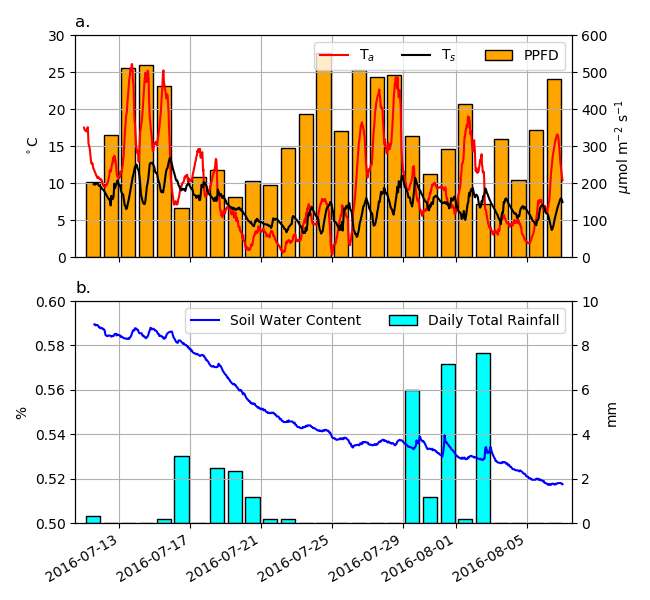

In [383]:
fig,ax = plt.subplots(2,1,figsize = (6.5,6),sharex=True)
ax[0].plot(T30['AirTC_Avg'],color='red',label = 'T$_a$')
ax[0].plot(T30['Temp'],color='black',label = 'T$_s$')
# ax[0].plot(T30['PPFD_Avg']*np.nan,color='orange',label = 'PPFD')
ax[0].bar(T30.index,T30['PPFD_Avg']*np.nan,facecolor='orange',edgecolor='black',label = 'PPFD')
ax[0].set_ylim(0,30)
yax2 = ax[0].twinx()
# yax2.plot(T30['PPFD_Avg'],color='orange',label='PPFD')
yax2.bar(H1.index+datetime.timedelta(hours=12),H1['PPFD_Avg'],
         facecolor='orange',edgecolor='black',label = 'PPFD')
yax2.set_ylim(0,600)

ax[0].grid()
ax[0].set_zorder(ax[0].get_zorder()+1)
ax[0].patch.set_visible(False)

yax2.set_ylabel('${\mu}$mol m$^{-2}$ s$^{-1}$')
ax[0].set_ylabel('$^\circ$C')
ax[0].legend(ncol = 3)
# yax2.legend(loc=3)
ax[0].set_title('a.',loc='left')

yax2 = ax[1].twinx()
yax2.bar(H1.index+datetime.timedelta(hours=12),H1['Rain_mm_Tot'],
         facecolor='cyan',edgecolor='black',label = 'Daily Total Rainfall')
# ax[1].bar(H1.index,H1['Rain_mm_Tot']*np.nan,label = 'Daily Total Rainfall')
yax2.set_ylim(0,10)

ax[1].plot(T30['VWC'],color='blue',label = 'Soil Water Content')
# ax[1].plot(fco2.RST.Master['VWC'],color='orange',label = 'Soil Water Content')
ax[1].bar(H1.index,H1['Rain_mm_Tot']*np.nan,facecolor='cyan',edgecolor='black',label = 'Daily Total Rainfall')
ax[1].set_ylim(.50,.6)
ax[1].grid()
ax[1].set_zorder(ax[1].get_zorder()+1)
ax[1].patch.set_visible(False)
yax2.set_ylabel('mm')
ax[1].set_ylabel('%')
ax[1].legend(ncol=2)
ax[0].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
ax[1].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
ax[1].set_title('b.',loc='left')
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig2.png',dpi=300)

<IPython.core.display.Javascript object>


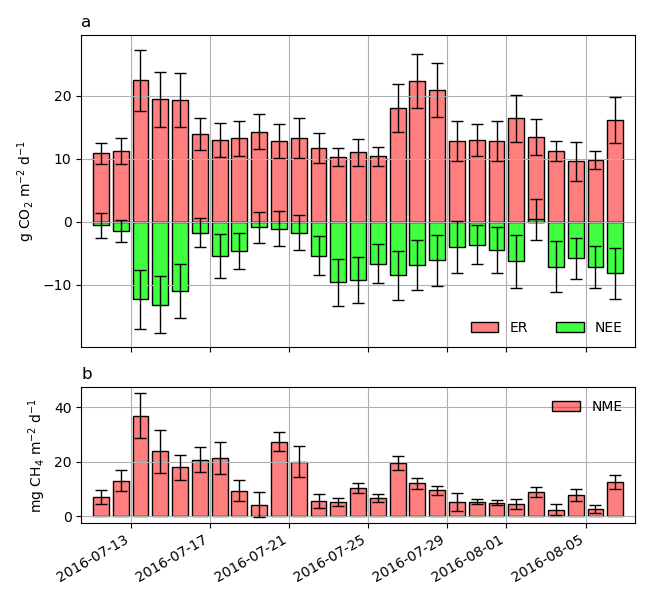

In [381]:
# H1s = H1s*48
fig = plt.figure(figsize = (6.5,6))
ax0 = plt.subplot2grid((3, 3), (0, 0), rowspan=2,colspan=3)
ax1 = plt.subplot2grid((3, 3), (2, 0), rowspan=1,colspan=3)
ax=[ax0,ax1]

# mult = (1e-6 * 44.0095 *3600)
mult = 24
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['ER_est']*mult,
          yerr = H1['ER_est_Pooled_PI']*mult,
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          edgecolor = 'black',facecolor=[1,0,0,.5],label='ER')
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['NEE']*mult,
#           yerr = H1['NEE_est_Pooled_CI']*mult,#/(48**.5)*stats.t.ppf(1-.025,48),#*mult,
          yerr = H1s['NEE']/(48**.5)*stats.t.ppf(1-.025,48)*mult,
#           yerr = H1['NEE_est_Pooled_CI']*mult,
          edgecolor = 'black',facecolor=[0,1,0,.75],
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          label='NEE')

ax[0].grid()
ax[0].set_title('a',loc='left')
# ax[0].set_ylabel('g CO${_2} $ m$^{-2}$ d$^{-1}$')
ax[0].set_ylabel('g CO${_2} $ m$^{-2}$ d$^{-1}$')#${\mu}$mol
ax[0].legend(#bbox_to_anchor=(0, -.052, 0.5, .1),
             facecolor='None',
             edgecolor='None',
             ncol=2,loc=4)

ax[0].set_xticklabels([])
# ax[0].set_ylim(-18.2,16.3)


# mult = 1/(1e-6 * 16.04246 *3600)

ax[1].bar(H1.index+datetime.timedelta(hours=12),H1['NME']*mult,
#           yerr = H1['NME_est_Pooled_CI']*mult,
          yerr = H1s['NME']/(48**.5)*stats.t.ppf(1-.025,48)*mult,
          edgecolor = 'black',facecolor=[1,0,0,.5],
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
#           alpha=.5,
          label ='NME')
ax[1].grid()
ax[1].set_title('b',loc='left')
# ax[1].set_ylabel('mg CH${_4} $ m$^{-2}$ d$^{-1}$')
ax[1].set_ylabel('mg CH${_4} $ m$^{-2}$ d$^{-1}$')#nmol

ax[0].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
ax[1].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
ax[1].legend(facecolor='None',
         edgecolor='None',)
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig3.png',dpi=300)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib

Mean ER:
ER        13.986829
ER_est    14.066672
ER2        9.094207
ER3       11.576413
dtype: float64

R2 Score:
ER_est:  0.4131600423436672 ER2:  0.23450566866942602 ER3:  0.3554159517047889

MSE:
ER_est:  0.11319788202871003 ER2:  0.1292853906633088 ER3:  0.11863647643414252
GPP     21.231983
GPP2    16.254183
GPP3    18.505401
dtype: float64
NEE       -7.245154
NEE_est   -7.326248
NEE2      -7.180856
NEE3      -6.928988
dtype: float64
921 921 1.4071661237785016
(921, 439)
NEE_est:  0.8966744667258253 NEE2:  0.7944691974691847 NEE3:  0.7824590402894881
NEE_est:  0.17209981752902456 NEE2:  0.24272529700394951 NEE3:  0.2497164212024647


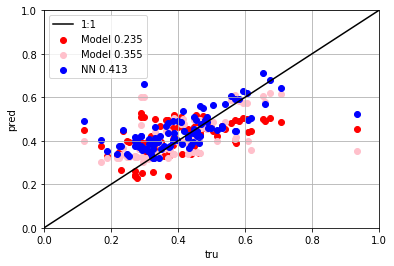

In [360]:

def P_func(PPFD,MQY,PM):
    cv =.7
    return((MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5)/(2*cv))
def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def R_func2(T,Q10,R10):
    return(R10*Q10**((T-10)/10))
Dark = T30.loc[T30['PPFD_Avg']<10,['Temp','fco2','ER_est','AirTC_Avg']].dropna()


# print(T30.loc[T30['PPFD_Avg']<10,['Temp','fco2']].drop)
popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['fco2'],p0=( 45.9262144,0.5875255,2.7508822))
popt_r2, pcov2 = curve_fit(R_func2, Dark['AirTC_Avg'], Dark['fco2'])#,p0=( 4.59262144,0.5875255,0.27508822))

#p0=( 74.59262144,0.8875255,2.27508822)
# print(metrics.r2_score(Dark['fco2'],R_func2(Dark['Temp'],*popt_r2)))

plt.figure()
plt.scatter(Dark['fco2'],R_func(Dark['Temp'],*popt_r),c='red',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),3)))
plt.scatter(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2),c='pink',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)),3))
           )
Dark['ER3'] = (R_func2(Dark['AirTC_Avg'],*popt_r2))
plt.scatter(Dark['fco2'],Dark['ER_est'],c='blue',
            label='NN '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER_est']),3)))
# plt.colorbar()
plt.plot([0,1],[0,1],label='1:1',color='black')
plt.ylabel('pred')
plt.xlabel('tru')
plt.legend()

plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
T30['ER2'] = R_func(T30['Temp'],*popt_r)
T30['ER3'] = R_func2(T30['AirTC_Avg'],*popt_r2)


P = T30[T30['PPFD_Avg']>=10]
P = P[['fco2','ER2','ER3','PPFD_Avg']].dropna()
popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER2']),p0=(.01,10))
popt_p3, pcov3 = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER3']),p0=(.01,10))
# T30['GPP2'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
T30['GPP2'] = P_func(T30['PPFD_Avg'],*popt_p)
T30['GPP3'] = P_func(T30['PPFD_Avg'],*popt_p3)
T30['NEE2'] = T30['ER2']-T30['GPP2']
T30['NEE3'] = T30['ER3']-T30['GPP3']

# popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], P['fco2']-,p0=(.003,12))
# Data['GPP'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
# Data['GPP_fill'] = P_func(Data['PPFD_Avg'],*popt_p)



# T30['GPP'] = T30['NEE']-T30['ER_est']
# T30['GPP2'] = T30['NEE_est']-T30['ER2']


Temp = T30.loc[np.isnan(T30['fco2'])==False]
print('Mean ER:')
print(Temp[['ER','ER_est','ER2','ER3']].mean()*mult)
# print(Dark['fco2'].mean())
print()
print('R2 Score:')
print('ER_est: ',metrics.r2_score(Dark['fco2'],Dark['ER_est']),
     'ER2: ',metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),
     'ER3: ',metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)))
print()
print('MSE:')
print('ER_est: ',metrics.mean_squared_error(Dark['fco2'],Dark['ER_est'])**.5,
     'ER2: ',metrics.mean_squared_error(Dark['fco2'],R_func(Dark['Temp'],*popt_r))**.5,
     'ER3: ',metrics.mean_squared_error(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2))**.5)
print(Temp[['GPP','GPP2','GPP3']].mean()*mult)
print(Temp[['NEE','NEE_est','NEE2','NEE3']].mean()*mult)
print(Temp['ER'].count(),T30['fco2'].count(),T30['ER'].count()/T30['fco2'].count())
print(Temp.shape)
TempNEE = Temp[['fco2','NEE','NEE_est','NEE2','NEE3']].dropna()
print('NEE_est: ',metrics.r2_score(TempNEE['fco2'],TempNEE['NEE_est']),
     'NEE2: ',metrics.r2_score(TempNEE['fco2'],TempNEE['NEE2']),
     'NEE3: ',metrics.r2_score(TempNEE['fco2'],TempNEE['NEE3']))
print('NEE_est: ',metrics.mean_squared_error(TempNEE['fco2'],TempNEE['NEE_est'])**.5,
     'NEE2: ',metrics.mean_squared_error(TempNEE['fco2'],TempNEE['NEE2'])**.5,
     'NEE3: ',metrics.mean_squared_error(TempNEE['fco2'],TempNEE['NEE3'])**.5)

Text(0, 0.5, 'Estimate')

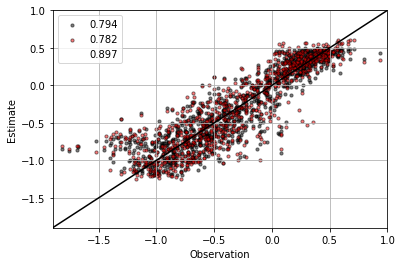

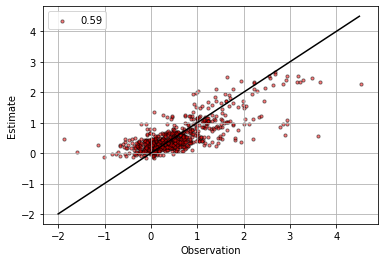

In [361]:
plt.figure()
# plt.scatter(T30['PPFD_Avg'],T30['fco2'],c='red',edgecolor='black',alpha=.5,s=10)
Temp=T30[['NEE2','NEE3','NEE_est','fco2']].dropna()
plt.plot([-1.9,1],[-1.9,1],color='black')
plt.scatter(T30['fco2'],T30['NEE2'],c='black',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE2']),3)))
plt.scatter(T30['fco2'],T30['NEE3'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE3']),3)))
plt.scatter(T30['fco2'],T30['NEE_est'],c='red',edgecolor='black',alpha=0,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE_est']),3)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')
plt.ylim(-1.9,1)
plt.xlim(-1.9,1)

plt.figure()
# plt.scatter(T30['PPFD_Avg'],T30['fco2'],c='red',edgecolor='black',alpha=.5,s=10)
Temp=T30[['NME_est','fch4']].dropna()
plt.plot([-2,4.5],[-2,4.5],color='black')
# plt.scatter(T30['fco2'],T30['NEE2'],c='black',edgecolor='black',alpha=.5,s=10,
#            label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE2']),3)))
# plt.scatter(T30['fco2'],T30['NEE3'],c='red',edgecolor='black',alpha=.5,s=10,
#            label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE3']),3)))
plt.scatter(T30['fch4'],T30['NME_est'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fch4'],Temp['NME_est']),3)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')
# plt.ylim(-1.9,1)
# plt.xlim(-1.9,1)



In [363]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def MapJobs(target,Range,N,Mask={},map_range=None):
    
    target.Project(Projector = None,Model = None)
    columns=[Range]
    l = 1
    for key in Mask.keys():
        columns.append(key)  
        l+=1
    for v in target.params['Inputs']:
        if v not in columns:
            columns.append(v)
    try:

        scaler = StandardScaler()
        scaler.fit(target.RST.Data[columns[l:]])
        Temp = scaler.transform(target.RST.Data[columns[l:]])
        Temp = pd.DataFrame(data = Temp,columns = columns[l:])
        kmeans = KMeans(n_clusters=N, random_state=0).fit(Temp)
#         print(kmeans)
#         print(Temp)
        Q = scaler.inverse_transform(kmeans.cluster_centers_)
    except:
        Q = []
        for col in columns[1:]:
            Q.append(Mask[col])
        Q=np.asanyarray(Q).T
        pass
    columns.append('target')
        
    def Make(Data,columns,map_range,values,C=20,Mask=None,i=0):
#         print(i)
        ranges = [np.linspace(map_range[0],map_range[1],C)]
#         print(ranges)
        for key in Mask.keys():
            ranges.append(np.ones(C)*Mask[key])
        for v in values:
            ranges.append(np.ones(C)*v)
        ranges.append(np.ones(C)*0)
        data = {}
        for (col,ran) in zip(columns,ranges):
            data[col]=ran
        data['key']=i
        
        return(pd.DataFrame(data = data))
    tarList=[]
    if map_range is None:
        map_range = [target.RST.Data[columns[0]].min(),target.RST.Data[columns[0]].max()]
    if len(Q) == 0:
        Data = Make(target.RST.Data,columns,
                    map_range=map_range,
                    values=[],Mask={key:item[i] for key, item in Mask.items()})
    for i,quantile in enumerate(Q):
        values = []
        for q in quantile:
            values.append(q)
#         print(Mask)
#         for key, item in Mask.items():
#             print(item)
#         for key,item in Mask.items():
#             print(key,item[0])
        if i == 0:
            Data = Make(target.RST.Data,columns,
                    map_range=map_range,#target.RST.Data[columns[0]].min(),1],#target.RST.Data[columns[0]].max()],
                    values=values,Mask={key:item[i] for key, item in Mask.items()})
        else:
            Data = Data.append(Make(target.RST.Data,columns,
                    map_range=map_range,#target.RST.Data[columns[0]].min(),1],#target.RST.Data[columns[0]].max()],
                    values=values,Mask={key:item[i] for key, item in Mask.items()},i=i))
            
    target.RST.Data=Data
#     print(target.RST.Data)
    target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
    target.Map()
    tarList.append(target.Data_Map)  
    return(tarList,Q,columns[1:-1],Data)


In [364]:
def Plot(ax,Label,Data,regressor,color,target,Interval=None,linestyle='-',mult=1):  
    rgba = color.copy()
    rgba.append(.25)
    Data = Data.sort_values(regressor)#.reset_index()
    try:
        Data['True']*=1
    except:
        Data['True']=0
        pass
    print(Data.loc[Data[regressor]==Data[regressor].min(),target])
    ax.plot(Data[regressor],Data[target]*mult,
            label= Label,
            linestyle=linestyle,
            linewidth=1.5,
            color = color)
    print(color)
    if Interval != None:
        ax.fill_between(Data[regressor],
                    mult*(Data[target]-Data[Interval]), 
                    mult*(Data[target]+Data[Interval]),
                    facecolor = rgba,
                    edgecolor = color,
                    linestyle=':',
                    linewidth=1,
#                     label = '95% Confidence Interval'
                   )


FloatProgress(value=0.0, description='Running:', max=30.0)

JustPar
0.8311370030853777


FloatProgress(value=0.0, description='Running:', max=30.0)

(20, 1) (20,)


<IPython.core.display.Javascript object>


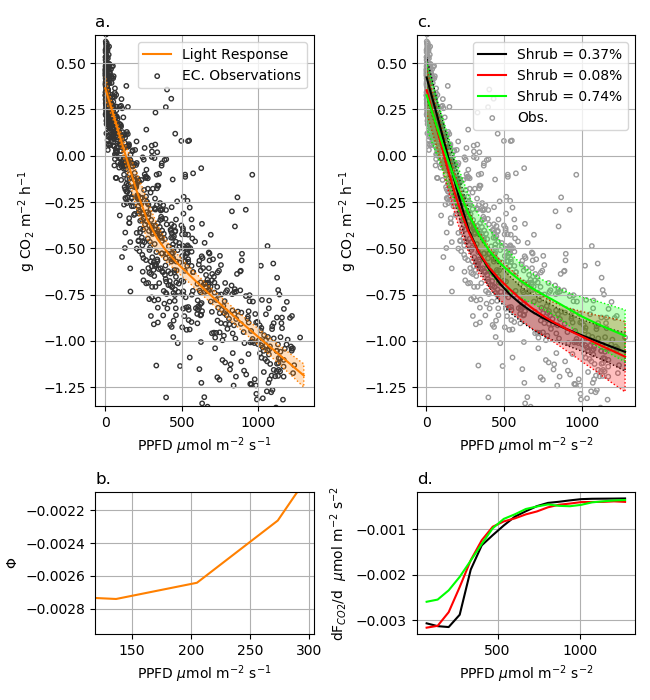

0    0.36424
Name: fco2, dtype: float32
[1, 0.5, 0]
-0.002740087772791203 -0.0006979281168717603
8.741750478744507
[3, 3]


FloatProgress(value=0.0, description='Running:', max=30.0)

(60, 4) (60,)
      VPD  $VWC$  Shrub
0  326.72   0.55   0.37
1  326.72   0.55   0.08
2  326.72   0.55   0.74
0    0.422734
Name: fco2, dtype: float32
[0, 0, 0]
-0.0031493138166335116 -0.0003184582454072262
20    0.353706
Name: fco2, dtype: float32
[1, 0, 0]
-0.00316255535882575 -0.0003821143443384834
40    0.326497
Name: fco2, dtype: float32
[0, 1, 0]
-0.0025924360449003266 -0.00035253573062616256


In [497]:
line = '-'
colors = [[1,.5,0]]
N=len(colors)
FirstRun = True
# FirstRun = False
Old = fco2.Model_Selection+''
# print(Old)
fco2.Model_Selection = 'PPFD_Avg'

T30 = Mapper(T30,fco2,'JustPar',Fill = False)
print('JustPar')
Temp = T30[['JustPar','fco2']].dropna()
print(metrics.r2_score(Temp['fco2'],Temp['JustPar']))


map_range=[0,1300]
differential='PPFD_Avg'
if FirstRun == True:
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(fco2,differential,N=N,
                         map_range=map_range
                        )
    
AllData=tarList_co2[0]
target = fco2
fig = plt.figure(figsize=(6.5,7))
# ,ax=plt.subplots(2,1,figsize=(7,10))


ax1 = plt.subplot2grid((3, 2), (0, 0),rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (0, 1),rowspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 1))

j = 0
# print(means_co2)
idx = []
ax = [ax1,ax2]#,ax3,ax4]
colorz = []
ax[0].scatter(target.RST.Master[differential],target.RST.Master['fco2']*1,
              edgecolor=[.2,.2,.2],
              facecolor='None',
              s=10,
              label = 'EC. Observations')

for key,color in zip(AllData['key'].unique(),colors):
    AllData['Select']=0
    
    label = 'Light Response'
    for i,col in enumerate(columns_co2):
        AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
#         print(AllData['Select'].max())
    Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
    Plot(ax[0],label,
         Data,differential,color,target.target,Interval = 'CI',
         linestyle=line,mult=1)
    ax[0].set_xlabel('PPFD ${\mu}$mol m$^{-2}$ s$^{-1}$')
    ax[0].set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
    tar = 'fco2'
#     label = 'Quantum Yield'
    ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
           linestyle = line,
           label = 'CI${_95%}$',
           color = color)
    ax[1].set_ylabel('${\Phi}$')
    ax[1].set_xlabel('PPFD ${\mu}$mol m$^{-2}$ s$^{-1}$')
    ax[1].set_ylim(-3e-3,0)
    ax[1].axes.ticklabel_format(axis='x',style='sci')
    j += 1
    print(np.min(Data[target.target].diff()/Data[differential].diff()),
          np.max(Data[target.target].diff()/Data[differential].diff()))
ax[0].legend(fontsize=10,loc=1)
# ax[1].legend(fontsize=10,loc=4)

ax[0].grid()
ax[1].grid()
ax[0].set_title('a.',loc='left')
ax[1].set_title('b.',loc='left')
print(Data['fco2'].iloc[0]*24)
ax[0].set_ylim([-1.35,.85])




fco2.Model_Selection = 'PPFD_Avg+VPD+VWC+Shrub'
COLORS = [[[0,0,0],[1,0,0],[0,1,0]],
#     ['black','blue','orange'],#+['red','orange','green','blue'],
          [[0,0,0],[1,0,0],[0,1,0]]]
LINES = [['-','-','-'],#+[':',':',':',':'],
         ['-','-','-']]#]
Ns=[]
for colors in COLORS:
    Ns.append(len(colors))
N = 3
# map_range = [T30['PPFD_Avg'].min(),T30['PPFD_Avg'].max()]
QV = 'Shrub'
Mask = {'VPD':[T30['VPD'].mean() for n in range(N)],#
           'VWC':np.asanyarray([T30['VWC'].mean() for n in range(N)]),#+[.58,.52,.58,.52]),
           QV:np.asanyarray([T30[QV].mean(),T30[QV].quantile(.05),T30[QV].quantile(.95)]),
           }
differentials = ['PPFD_Avg','VPD']
map_ranges = [[T30[differentials[0]].min(),T30[differentials[0]].max()],
             [T30[differentials[1]].min(),T30[differentials[1]].max()]]
# targets = [fco2,fco2]
# k = 0
# SCENARIOS = []
xlbs = [' ${\mu}$mol m$^{-2}$ s$^{-2}$',' Pa']
# for Mask,map_range,differential,N,colors,lines,target,xlb in zip(Masks,
# map_ranges,differentials,Ns,COLORS,LINES,targets,xlbs):
# Mask = Masks[0]
map_range=map_ranges[0]
differential=differentials[0]
N=3
print(Ns)
colors = COLORS[0]
lines = LINES[0]
target = fco2
xlb = xlbs[0]
if FirstRun == True:
    CO21 = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(target,differential,N=N,
         Mask=Mask,map_range=map_range)
    CO21.append([tarList_co2,means_co2,columns_co2,Data_co2])
else:
    tarList_co2,means_co2,columns_co2,Data_co2 = CO21[k]
    
AllData=tarList_co2[0]
#     idx = []
# if k == 0:
#     ax = [ax1,ax2]#,ax3]
# else:
ax = [ax3,ax4]
colorz = []
if target == ER:
    val = 'ER'
else:
    val = 'fco2'
if k == 1:
    Temp = target.RST.Master.loc[target.RST.Master['PPFD_Avg']>750,[differential,val,'PPFD_Avg']]
    Temp = Temp.loc[Temp['PPFD_Avg']<1250,[differential,val]]
    ax[0].scatter(Temp[differential],Temp[val]*1,
                  edgecolor=[.6,.6,.6],
                  facecolor='None',s=10,label = 'Obs.')
else:
    ax[0].scatter(target.RST.Master[differential],target.RST.Master[val]*1,
              edgecolor=[.6,.6,.6],
              facecolor='None',s=10,label = 'Obs.')


cols = [aliases[col] for col in columns_co2]
Scenarios = pd.DataFrame(data=means_co2,columns=cols)
Scenarios = Scenarios.round(2)
print(Scenarios)
SCENARIOS.append(Scenarios)
j = 0
for key,color,line in zip(AllData['key'].unique(),colors,lines):
    List = [color]
    List+=['white'for i in range(len(columns_co2))]
    colorz.append(List)
    AllData['Select']=0

    label = QV+' = '+str(Scenarios[QV].iloc[j].round(2))+'%'#'# '+str(j)
#         idx.append(str(j))
    for i,col in enumerate(columns_co2):
        AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
    Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
    Plot(ax[0],label,
         Data,differential,color,target.target,Interval = 'CI',
         linestyle=line,mult=1)
    tar = 'F$_{CO2}$'

    ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
           linestyle = line,
           label = label,
           color = color)
    j += 1

    print(np.min(Data[target.target].diff()/Data[differential].diff()),
          np.max(Data[target.target].diff()/Data[differential].diff()))

ax[0].set_xlabel(aliases[differential]+xlb)
ax[0].set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
ax[1].set_ylabel('d'+tar+'/d '+xlb)
ax[1].set_xlabel(aliases[differential]+xlb)
ax[0].legend(fontsize=10,loc=1)

ax[0].grid()
ax[1].grid()
#     if k == 0:
ax1.set_ylim([-1.35,.65])
ax3.set_ylim([-1.35,.65])
#     else:# val == 'ER':
#         ax[0].set_ylim([-1.25,-.2])

ax[0].set_title('c.',loc='left')
ax[1].set_title('d.',loc='left')
        
#     k+=1


plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig5.png',dpi=300)


# plt.tight_layout()
# plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig6.png',dpi=300)

In [413]:



# line = '-'
# colors = [[.5,1,0]]
# N=len(colors)
# Old = fch4.Model_Selection+''
# fch4.Model_Selection = 'Sedge'

# T30 = Mapper(T30,fch4,'JustSedge',Fill = False)
# print('JustSedge')
# Temp = T30[['JustSedge','fco2']].dropna()
# print(metrics.r2_score(Temp['fch4'],Temp['JustSedge']))



# map_range=[0,.6]
# differential='Sedge'
# if FirstRun == True:
#     tarList_ch4,means_ch4,columns_ch4,Data_ch4=MapJobs(fch4,differential,N=N,
#                          map_range=map_range
#                         )
    
# AllData=tarList_ch4[0]
# target = fch4

# j = 0
# idx = []
# ax = [ax3,ax4]
# colorz = []
# ax[0].scatter(target.RST.Master[differential],target.RST.Master['fch4']*1,
#               edgecolor=[.2,.2,.2],
#               facecolor='None',
#               s=10,
#               label = 'EC. Observations')

# for key,color in zip(AllData['key'].unique(),colors):
#     AllData['Select']=0
#     label = 'Sedge Response'
#     for i,col in enumerate(columns_ch4):
#         AllData.loc[np.abs(AllData[col]-means_ch4[key,i])<1e-4,'Select']+=1
# #         print(AllData['Select'].max())
#     Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
#     Plot(ax[0],label,
#          Data,differential,color,target.target,Interval = 'CI',
#          linestyle=line,mult=1)
#     ax[0].set_xlabel('Sedge %')
#     ax[0].set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
#     tar = 'fch4'
# #     label = 'Quantum Yield'
#     ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
#            linestyle = line,
#            label = 'CI${_95%}$',
#            color = color)
#     ax[1].set_ylabel('${\Phi}$')
#     ax[1].set_xlabel('Sedge %')
# #     ax[1].set_ylim(-3e-3,0)
#     ax[1].axes.ticklabel_format(axis='x',style='sci')
#     j += 1
#     print(np.min(Data[target.target].diff()/Data[differential].diff()),
#           np.max(Data[target.target].diff()/Data[differential].diff()))
# print(Data['fch4'].iloc[0]*24)
# ax[0].legend(fontsize=10,loc=1)
# # ax[1].legend(fontsize=10,loc=4)

# ax[0].grid()
# ax[1].grid()
# ax[0].set_title('c.',loc='left')
# ax[1].set_title('d.',loc='left')fco2.Model_Selection = 'PPFD_Avg+VPD+VWC+Shrub'

<__main__.ResultMap object at 0x0000013A2EA7A898> PPFD_Avg 3 {'VPD': [326.72376169868653, 326.72376169868653, 326.72376169868653], 'VWC': array([0.54914343, 0.54914343, 0.54914343]), 'Shrub': array([0.37062568, 0.01      , 0.78      ])} [1.757, 1276.0]


In [466]:
# print(T30.loc[T30['PPFD_Avg']<10,differentials[1]].max())
# Scenarios = Scenarios.reset_index(drop = True)
print(Scenarios)
# print(T30['PPFD_Avg'].mean())
print(Scenarios[QV].iloc[i].round(0))
# print(i)

          VPD     Shrub  PPFD_Avg
0  326.720000  0.370000   750.000
1  326.720000  0.370000   333.280
2  326.723762  0.370626     1.757
333.0
2


<IPython.core.display.Javascript object>


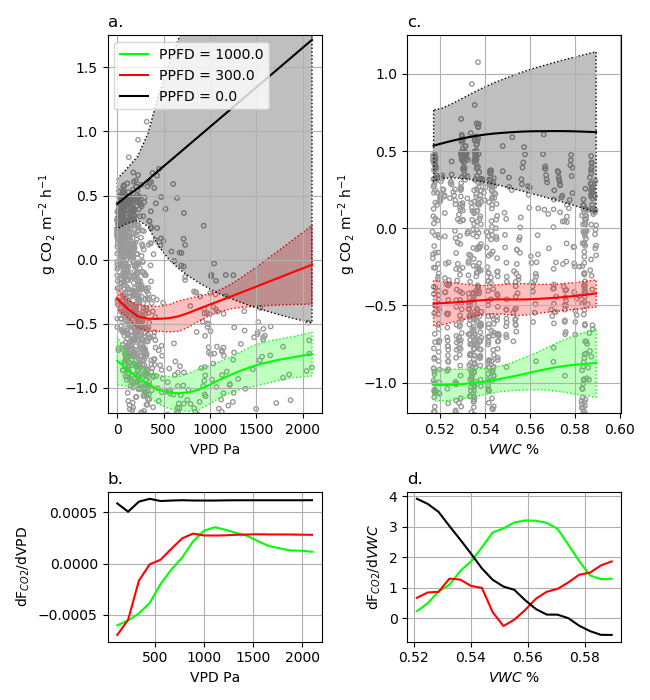

FloatProgress(value=0.0, description='Running:', max=30.0)

(40, 4) (40,)


FloatProgress(value=0.0, description='Running:', max=30.0)

(20, 4) (20,)
VWC 0.5491434345425869
Shrub 0.37062568181450656
PPFD_Avg 1000.0
0   -0.791153
Name: fco2, dtype: float32
[0, 1, 0]
VWC 0.5491434345425869
Shrub 0.37062568181450656
PPFD_Avg 300.0
20   -0.305686
Name: fco2, dtype: float32
[1, 0, 0]
VWC 0.5491434345425869
Shrub 0.37062568181450656
PPFD_Avg 0.0
0    0.435134
Name: fco2, dtype: float32
[0, 0, 0]


FloatProgress(value=0.0, description='Running:', max=30.0)

(40, 4) (40,)


FloatProgress(value=0.0, description='Running:', max=30.0)

(20, 4) (20,)
0   -1.016852
Name: fco2, dtype: float32
[0, 1, 0]
20   -0.487975
Name: fco2, dtype: float32
[1, 0, 0]
0    0.535269
Name: fco2, dtype: float32
[0, 0, 0]


In [504]:
FirstRun=True

if FirstRun == True:  
    CO22A = []

fig = plt.figure(figsize=(6.5,7))

ax1 = plt.subplot2grid((3, 2), (0, 0),rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (0, 1),rowspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 1))

# differential='PPFD_Avg'
# fco2.Model_Selection = 'PPFD_Avg+VPD'#+VWC+Shrub'
fco2.Model_Selection = 'PPFD_Avg+VPD+VWC+Shrub'
COLORS = [[[0,1,0],[1,0,0]],#+['red','orange','green','blue'],
          [[0,0,0],[1,0,0]]]
LINES = [['-','-'],
         [':',':']]

Ns=[]
for colors in COLORS:
    Ns.append(len(colors))
N = 2
M = 1
QV = 'PPFD_Avg'
Masks = [{'VWC':np.asanyarray([T30['VWC'].mean() for n in range(N)]),#
           'Shrub':np.asanyarray([T30['Shrub'].mean() for n in range(N)]),#+[.58,.52,.58,.52]),
           'PPFD_Avg':[1000,300],
           },
         {'VWC':np.asanyarray([T30['VWC'].mean() for n in range(M)]),#
           'Shrub':np.asanyarray([T30['Shrub'].mean() for n in range(M)]),#+[.58,.52,.58,.52]),
           'PPFD_Avg':[0],
           },
        ]
differentials = ['VPD','VPD']
map_ranges = [[T30[differentials[0]].min(),T30[differentials[0]].max()],
             [T30[differentials[1]].min(),T30[differentials[1]].max()]]#T30.loc[T30['PPFD_Avg']<10,differentials[1]].max()]]
targets = [fco2,fco2]
k = 0
SCENARIOS = []
xlbs = [' pa',' pa']
if FirstRun == True:
    CO22A = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(fco2,'VPD',
                                                       N=2,
                                                       Mask=Masks[0],
                                                       map_range=map_ranges[0]
                                                      )
    CO22A.append([tarList_co2,means_co2,columns_co2,Data_co2])
    
#     cols = [aliases[col] for col in columns_co2]
    Scenarios = pd.DataFrame(data=means_co2,columns=columns_co2)
#     Scenarios = Scenarios.round(2)
    
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(ER,'VPD',
                                                       N=1,
                                                       Mask=Masks[1],
                                                       map_range=map_ranges[1]
                                                      )
    CO22A.append([tarList_co2,means_co2,columns_co2,Data_co2])
    
#     cols = [aliases[col] for col in columns_co2]
    Scenarios2 = pd.DataFrame(data=means_co2,columns=columns_co2)
    Scenarios = Scenarios.round(2)
    Scenarios = Scenarios.append(Scenarios2)
    Scenarios = Scenarios.reset_index(drop = True)
#     print(SCENARIOS)
i = 0
for k in range(2):
    differential = differentials[k]
    colors = COLORS[k]
    tarList_co2,means_co2,columns_co2,Data_co2 = CO22A[k]
    AllData=tarList_co2[0]
    j = 0
    idx = []
    ax = [ax1,ax2]
    colorz = []
    if i == 0:
        ax[0].scatter(target.RST.Master[differentials[0]],target.RST.Master[val]*1,
                  edgecolor=[.6,.6,.6],
                  facecolor='None',s=10)#,label = 'Obs.')
    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List = [color]
        List+=['white'for p in range(len(columns_co2))]
        colorz.append(List)
        AllData['Select']=0
        label = aliases[QV]+' = '+str(Scenarios[QV].iloc[i].round(0))
        for o,col in enumerate(columns_co2):
            print(col,means_co2[key,o])
            AllData.loc[np.abs(AllData[col]-means_co2[key,o])<1e-4,'Select']+=1
        intt = 'CI'
        if k == 1:
            intt='PI'
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        Plot(ax[0],label,
             Data,differential,color,target.target,Interval = intt,
             linestyle=line,mult=1)
        tar = 'F$_{CO2}$'

        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1
        i += 1

    ax[0].set_xlabel(aliases[differential]+' Pa')
    ax[0].set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
    ax[1].set_ylabel('d'+tar+'/d'+aliases[differential])
    ax[1].set_xlabel(aliases[differential]+' Pa')
#     if k == 0:
#         loc = 2
#     else:
#         loc = 1
#     ax[0].legend(fontsize=10,loc=loc)

    ax[0].grid()
    ax[1].grid()
    if val == 'fco2':
        ax[0].set_title('a.',loc='left')
        ax[1].set_title('b.',loc='left')
    k+=1



COLORS = [[[0,1,0],[1,0,0]],#+['red','orange','green','blue'],
      [[0,0,0],[1,0,0]]]
LINES = [['-','-'],
         [':',':']]

Ns=[]
for colors in COLORS:
    Ns.append(len(colors))
N = 2
M = 1
QV = 'PPFD_Avg'
Masks = [{'VPD':np.asanyarray([T30['VPD'].mean() for n in range(N)]),#
           'Shrub':np.asanyarray([T30['Shrub'].mean() for n in range(N)]),#+[.58,.52,.58,.52]),
           'PPFD_Avg':[1000,300],
           },
         {'VPD':np.asanyarray([T30['VPD'].mean() for n in range(M)]),#
           'Shrub':np.asanyarray([T30['Shrub'].mean() for n in range(M)]),#+[.58,.52,.58,.52]),
           'PPFD_Avg':[0],
           },
        ]



differentials = ['VWC','VWC']
map_ranges = [[T30[differentials[0]].min(),T30[differentials[0]].max()],
             [T30[differentials[1]].min(),T30[differentials[1]].max()]]#T30.loc[T30['PPFD_Avg']<10,differentials[1]].max()]]
targets = [fco2,fco2]
k = 0
SCENARIOS = []
xlbs = [' %',' %']
if FirstRun == True:
    CO22B = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(fco2,'VWC',
                                                       N=2,
                                                       Mask=Masks[0],
                                                       map_range=map_ranges[0]
                                                      )
    CO22B.append([tarList_co2,means_co2,columns_co2,Data_co2])
    
#     cols = [aliases[col] for col in columns_co2]
    Scenarios = pd.DataFrame(data=means_co2,columns=columns_co2)
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(ER,'VWC',
                                                       N=1,
                                                       Mask=Masks[1],
                                                       map_range=map_ranges[1]
                                                      )
    CO22B.append([tarList_co2,means_co2,columns_co2,Data_co2])
    Scenarios2 = pd.DataFrame(data=means_co2,columns=columns_co2)
    Scenarios = Scenarios.round(2)
    Scenarios = Scenarios.append(Scenarios2)
    Scenarios = Scenarios.reset_index(drop = True)
#     print(SCENARIOS)
i = 0
for k in range(2):
    differential = differentials[k]
    colors = COLORS[k]
    tarList_co2,means_co2,columns_co2,Data_co2 = CO22B[k]
    AllData=tarList_co2[0]
#     target = fco2
    j = 0
    idx = []
#     if k == 0:
    ax = [ax3,ax4]#,ax3]
    
    
    colorz = []
    if i == 0:
#         val = 'ER'k+j
        ax[0].scatter(target.RST.Master[differentials[0]],target.RST.Master[val]*1,
                  edgecolor=[.6,.6,.6],
                  facecolor='None',s=10)#,label = 'Obs.')

    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List = [color]
        List+=['white'for p in range(len(columns_co2))]
        colorz.append(List)
        AllData['Select']=0

        label = aliases[QV]+' = '+str(Scenarios[QV].iloc[i].round(0))
#         idx.append(str(j))
        for o,col in enumerate(columns_co2):
            AllData.loc[np.abs(AllData[col]-means_co2[key,o])<1e-4,'Select']+=1
        intt = 'CI'
        if k == 1:
            intt='PI'
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        Plot(ax[0],label,
             Data,differential,color,target.target,Interval = intt,
             linestyle=line,mult=1)
        tar = 'F$_{CO2}$'

        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1
        i += 1

    k+=1
    
ax[0].set_xlabel(aliases[differential]+' %')
ax[0].set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
ax[1].set_ylabel('d'+tar+'/d'+aliases[differential])
ax[1].set_xlabel(aliases[differential]+' %')

ax1.legend(fontsize=10,loc=0)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax[0].set_title('c.',loc='left')
ax[1].set_title('d.',loc='left')
ax1.set_ylim([-1.2,1.75])
ax3.set_ylim([-1.2,1.25])
    
    
    
    
plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig6.png',dpi=300)
   


In [475]:
print(Data)
plt.scatter(T30['VPD'],T30['AirTC_Avg'])

    PPFD_Avg         VPD       VWC     Shrub  key      fco2   Var_reg  \
0      1.757  326.723762  0.517250  0.370626    0  0.521559  0.002176   
1      1.757  326.723762  0.521053  0.370626    0  0.536502  0.001692   
2      1.757  326.723762  0.524855  0.370626    0  0.550821  0.001454   
3      1.757  326.723762  0.528658  0.370626    0  0.564254  0.001509   
4      1.757  326.723762  0.532461  0.370626    0  0.576394  0.001842   
5      1.757  326.723762  0.536263  0.370626    0  0.586431  0.002483   
6      1.757  326.723762  0.540066  0.370626    0  0.595087  0.003466   
7      1.757  326.723762  0.543868  0.370626    0  0.601837  0.004595   
8      1.757  326.723762  0.547671  0.370626    0  0.606244  0.005719   
9      1.757  326.723762  0.551474  0.370626    0  0.609004  0.006883   
10     1.757  326.723762  0.555276  0.370626    0  0.610819  0.008114   
11     1.757  326.723762  0.559079  0.370626    0  0.611617  0.009384   
12     1.757  326.723762  0.562882  0.370626    0  

<IPython.core.display.Javascript object>


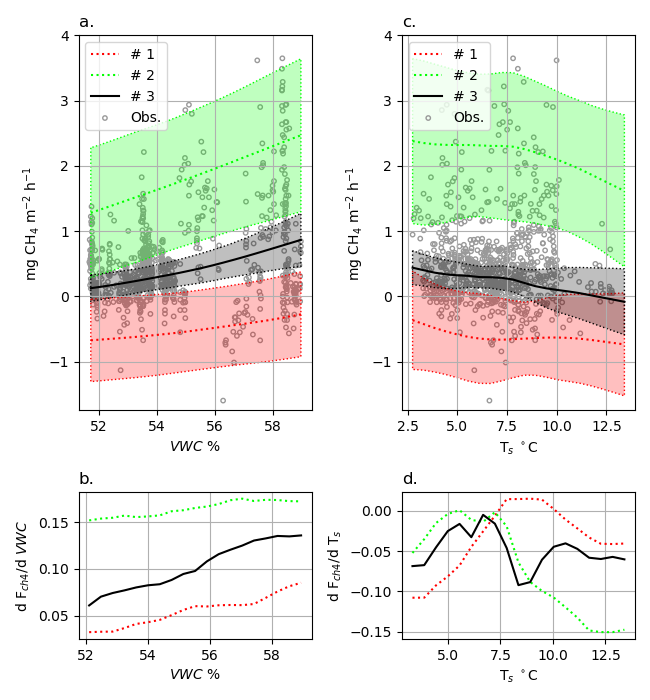

FloatProgress(value=0.0, description='Running:', max=30.0)

(60, 5) (60,)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0   -0.674071
Name: fch4, dtype: float32
[1, 0, 0]


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


20    1.279815
Name: fch4, dtype: float32
[0, 1, 0]


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


40    0.124883
Name: fch4, dtype: float32
[0, 0, 0]
[[3.87373565 7.22671319 0.27       0.01      ]
 [3.87373565 7.22671319 0.04       0.54      ]
 [3.87373565 7.22671319 0.04       0.04      ]] ['1', '2', '3'] ['$\\overline{U}$', 'T$_{s}$', 'OOB', 'Sedge']
  Scenario  $\overline{U}$  T$_{s}$   OOB  Sedge
1        1            3.87     7.23  0.27   0.01
2        2            3.87     7.23  0.04   0.54
3        3            3.87     7.23  0.04   0.04


FloatProgress(value=0.0, description='Running:', max=30.0)

(60, 5) (60,)
0   -0.36586
Name: fch4, dtype: float32
[1, 0, 0]
20    2.378586
Name: fch4, dtype: float32
[0, 1, 0]
40    0.438233
Name: fch4, dtype: float32
[0, 0, 0]
[[3.87373565 0.52       0.27       0.01      ]
 [3.87373565 0.58       0.04       0.54      ]
 [3.87373565 0.54914343 0.04       0.01      ]] ['1', '2', '3'] ['$\\overline{U}$', '$VWC$', 'OOB', 'Sedge']
  Scenario  $\overline{U}$  $VWC$   OOB  Sedge
1        1            3.87   0.52  0.27   0.01
2        2            3.87   0.58  0.04   0.54
3        3            3.87   0.55  0.04   0.01


In [515]:
FirstRun=True
if FirstRun == True:  
    CH41 = []
fig = plt.figure(figsize=(6.5,7))
fch4.Model_Selection = 'wind_speed+Temp+VWC+Sedge+Out_of_Basin'

ax1 = plt.subplot2grid((3, 2), (0, 0),rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (0, 1),rowspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 1))

COLORS = [[[1,0,0],[0,1,0],[0,0,0]],#+['red','orange','green','blue'],
          [[1,0,0],[0,1,0],[0,0,0],[1,1,0]]]
# 'red','green',
# 'red','green',

LINES = [[':',':','-'],#,'-','-'],#+[':',':',':',':'],
         [':',':','-','-']]#,'-','-']]
Ns=[]
for colors in COLORS:
    Ns.append(len(colors))
N = 3
# M = 2
Masks = [
    {'wind_speed':[T30['wind_speed'].mean() for i in range(N)],
      'Temp':[T30['Temp'].mean() for i in range(N)],
      'Out_of_Basin':[.28,.03,.03],
      'Sedge':[.00,.56,.0],
     },
    
    {'wind_speed':[T30['wind_speed'].mean() for i in range(N)],
      'VWC':[.52,.58,T30['VWC'].mean()],# for i in range(N)],
      'Out_of_Basin':[.28,.03,.03],
      'Sedge':[.00,.56,.0],
#     {'wind_speed':[T30['wind_speed'].mean() for i in range(M)],
#       'VWC':[.52,.52,.58,.58],
#       'Out_of_Basin':[.27,.04,.27,.04],
#       'Sedge':[.01,.54,.01,.54],
     }
        ]
differentials = ['VWC','Temp']
map_ranges = [[T30[differentials[0]].min(),T30[differentials[0]].max()],
             [T30[differentials[1]].min(),T30[differentials[1]].max()]]
targets = [fch4,fch4]
k = 0
SCENARIOS = []
xlbs = [' %',' $^\circ$C']
for Mask,map_range,differential,N,colors,lines,target,xlb in zip(Masks,map_ranges,
                                                                 differentials,Ns,COLORS,LINES,targets,xlbs):
    if FirstRun == True:
        tarList_ch4,means_ch4,columns_ch4,Data_ch4=MapJobs(target,differential,N=N,
             Mask=Mask,map_range=map_range)
        CH41.append([tarList_ch4,means_ch4,columns_ch4,Data_ch4])
    else:
        tarList_ch4,means_ch4,columns_ch4,Data_ch4 = CH41[k]
    AllData=tarList_ch4[0]
#     print(tarList_ch4,means_ch4,columns_ch4,Data_ch4)
    j = 1
    idx = []
    if k == 0:
        ax = [ax1,ax2]#,ax3]
    else:
        ax = [ax3,ax4]
    colorz = []
    val = 'fch4'
    if differential == 'VWC':
        conv = 100
    else:
        conv = 1
    ax[0].scatter(target.RST.Master[differential]*conv,target.RST.Master[val],
                  edgecolor=[.6,.6,.6],
                  facecolor='None',s=10,label = 'Obs.')

    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List = [color]
        List+=['white'for i in range(len(columns_ch4))]
        colorz.append(List)
        AllData['Select']=0
        label = '# '+str(j)
        idx.append(str(j))
        for i,col in enumerate(columns_ch4):
            AllData.loc[np.abs(AllData[col]-means_ch4[key,i])<1e-4,'Select']+=1
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        if differential=='VWC':
            Data[differential]*=100
        Plot(ax[0],label,
             Data,differential,color,target.target,Interval = 'CI',
             linestyle=line,mult=1)
        tar = 'F$_{ch4}$'

        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1
    cols = [aliases[col] for col in columns_ch4]
    print(means_ch4,idx,cols)
    Scenarios = pd.DataFrame(data=means_ch4,index=idx,columns=cols)
    # Scenarios['VPD'] = T30['VPD'].mean()
    Scenarios = Scenarios.round(2)
    # Scenarios['VPD'] = Scenarios['VPD'].astype(int)
    Scenarios['Scenario']=idx
    Scenarios = Scenarios[['Scenario']+cols]

    ax[0].set_xlabel(aliases[differential]+xlb)
    ax[0].set_ylabel('mg CH$_4$ m$^{-2}$ h$^{-1}$')
    ax[1].set_ylabel('d '+tar+'/d '+aliases[differential])
    ax[1].set_xlabel(aliases[differential]+xlb)
    ax[0].legend(fontsize=10,loc=2)

    ax[0].grid()
    ax[1].grid()
#     if val == 'fch4':
    ax[0].set_ylim([-1.75,4])
#     elif val == 'fch4':
#         ax[0].set_ylim([0,1.2])
        
#     ax[0].set_xlim([T30[differential].min()-T30[differential].min()*.01,T30[differential].max()+T30[differential].max()*.01])

    if k == 0:
        ax[0].set_title('a.',loc='left')
        ax[1].set_title('b.',loc='left')
    else:
        ax[0].set_title('c.',loc='left')
        ax[1].set_title('d.',loc='left')
        
    k+=1
    
    print(Scenarios)
      

    SCENARIOS.append(Scenarios)

plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig9.png',dpi=300)

In [517]:
print(T30['Out_of_Basin'].min(),T30['Sedge'].min())
print(T30['Out_of_Basin'].max(),T30['Sedge'].max())

0.029199863297806918 1.1528969880685471e-95
0.27995654752163224 0.5558626703596617


<IPython.core.display.Javascript object>


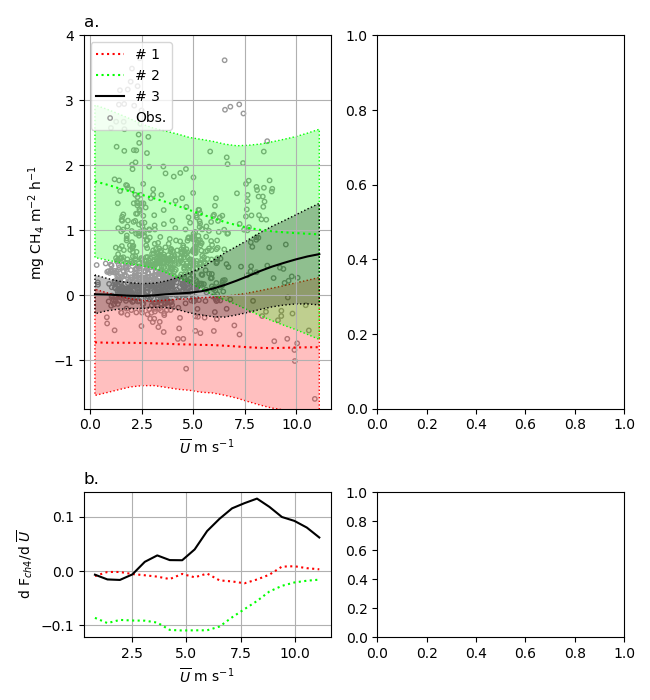

FloatProgress(value=0.0, description='Running:', max=30.0)

(60, 5) (60,)
0   -0.727261
Name: fch4, dtype: float32
[1, 0, 0]
-0.02264690870678464 0.008810023807806114
20    1.751853
Name: fch4, dtype: float32
[0, 1, 0]
-0.10988174389650436 -0.01595772995030387
40    0.012363
Name: fch4, dtype: float32
[0, 0, 0]
-0.01649456333278109 0.13374008154143618
  Scenario  $VWC$  T$_{s}$   OOB  Sedge
1        1   0.52     7.23  0.28   0.00
2        2   0.52     7.23  0.03   0.56
3        3   0.52     7.23  0.03   0.00


In [520]:
FirstRun=True
if FirstRun == True:  
    CH42 = []

fig = plt.figure(figsize=(6.5,7))

ax1 = plt.subplot2grid((3, 2), (0, 0),rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (0, 1),rowspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 1))

COLORS = [[[1,0,0],[0,1,0],[0,0,0]],#+['red','orange','green','blue'],
#           ['red','green','black']
         ]
# 'red','green',
# 'red','green',

LINES = [[':',':','-'],#,'-','-'],#+[':',':',':',':'],
         [':',':','-']]#,'-','-']]
Ns=[]
for colors in COLORS:
    Ns.append(len(colors))
N = 3
Masks = [{#'PPFD_Avg':[T30['PPFD_Avg'].mean() for i in range(N)],
      'VWC':[T30['VWC'].quantile(.1) for i in range(N)],
      'Temp':[T30['Temp'].mean() for i in range(N)],
      'Out_of_Basin':[.28,.03,.03],
      'Sedge':[.00,.56,.0],
     },
#          {'Temp':[T30['Temp'].mean() for i in range(N)],
#       'wind_speed':[T30['wind_speed'].mean() for i in range(N)],
#       'VWC':[T30['VWC'].mean() for i in range(N)],
#       'Upland':[.15,0,T30['Upland'].mean()],
#       'Sedge':[0,.55,T30['Sedge'].mean()],
#      }
        ]
differentials = ['wind_speed']#,'PPFD_Avg']
map_ranges = [[T30[differentials[0]].min(),T30[differentials[0]].max()]]
#              [T30[differentials[1]].min(),T30[differentials[1]].max()]]
targets = [fch4,fch4]
k = 0
SCENARIOS = []
xlbs = [' m s$^{-1}$',' umol m$^{-2}$ s$^{-2}$']
for Mask,map_range,differential,N,colors,lines,target,xlb in zip(Masks,
map_ranges,differentials,Ns,COLORS,LINES,targets,xlbs):
    if FirstRun == True:
        tarList_ch4,means_ch4,columns_ch4,Data_ch4=MapJobs(target,differential,N=N,
             Mask=Mask,
                                 map_range=map_range
                                )
        CH42.append([tarList_ch4,means_ch4,columns_ch4,Data_ch4])
    else:
        tarList_ch4,means_ch4,columns_ch4,Data_ch4 = CH42[k]
    AllData=tarList_ch4[0]
#     target = fch4
    j = 1
#     print(means_ch4)
    idx = []
    if k == 0:
        ax = [ax1,ax2]#,ax3]
    else:
        ax = [ax3,ax4]
    colorz = []
    if target == fch4:
        val = 'fch4'
    else:
        val = 'fch4'
    if differential=='VWC':
        m = 100
    else:
        m = 1
    ax[0].scatter(target.RST.Master[differential]*m,target.RST.Master[val]*1,
                  edgecolor=[.6,.6,.6],
                  facecolor='None',s=10,label = 'Obs.')

    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List = [color]
        List+=['white'for i in range(len(columns_ch4))]
        colorz.append(List)
        AllData['Select']=0

        label = '# '+str(j)
        idx.append(str(j))
        for i,col in enumerate(columns_ch4):
            AllData.loc[np.abs(AllData[col]-means_ch4[key,i])<1e-4,'Select']+=1
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        if differential=='VWC':
            Data[differential]*=100
        Plot(ax[0],label,
             Data,differential,color,target.target,Interval = 'CI',
             linestyle=line,mult=1)
        tar = 'F$_{ch4}$'

        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1

        print(np.min(Data[target.target].diff()/Data[differential].diff()),
              np.max(Data[target.target].diff()/Data[differential].diff()))

    ax[0].set_xlabel(aliases[differential]+xlb)
    ax[0].set_ylabel('mg CH$_4$ m$^{-2}$ h$^{-1}$')
    ax[1].set_ylabel('d '+tar+'/d '+aliases[differential])
    ax[1].set_xlabel(aliases[differential]+xlb)
    ax[0].legend(fontsize=10,loc=2)

    ax[0].grid()
    ax[1].grid()
    
    ax[0].set_ylim([-1.75,4])
    if k == 0:
        ax[0].set_title('a.',loc='left')
        ax[1].set_title('b.',loc='left')
    else:
        ax[0].set_title('c.',loc='left')
        ax[1].set_title('d.',loc='left')
        
        
    k+=1
    try:

        cols = [aliases[col] for col in columns_ch4]
        Scenarios = pd.DataFrame(data=means_ch4,index=idx,columns=cols)
        # Scenarios['VPD'] = T30['VPD'].mean()
        Scenarios = Scenarios.round(2)
        # Scenarios['VPD'] = Scenarios['VPD'].astype(int)
        Scenarios['Scenario']=idx
        Scenarios = Scenarios[['Scenario']+cols]
        print(Scenarios)
    except:
        pass

plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig10.png',dpi=300)

0.06767891498290045
0.762783899858244
['PPFD_Avg', 'VPD', 'VWC', 'Shrub']
0.03976717793122806
0.8606151581349577


C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


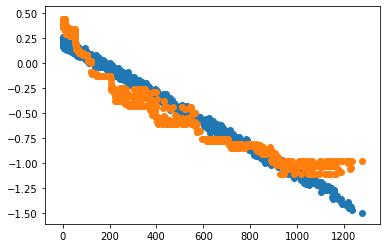

In [320]:
fco2.Project(Projector = None,Model = None)
# fco2.Project(Projector = None,Model = None)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(fco2.RST.Data[fco2.params['Inputs']],fco2.RST.Data[fco2.params['target']])


y_pred = reg.predict(fco2.RST.Data[fco2.params['Inputs']])
print(metrics.mean_squared_error(y_pred,fco2.RST.Data[fco2.params['target']]))
print(metrics.r2_score(fco2.RST.Data[fco2.params['target']],y_pred))
y_pred2 =  reg.predict(fco2.RST.Data[fco2.params['Inputs']])
# reg.coef_

# reg.intercept_ 

# reg.predict(np.array([[3, 5]]))
             
# print()
fco2.RST.Data['y_pred2']=y_pred2
plt.figure()
Var = 'Sedge'
Var = 'PPFD_Avg'
plt.scatter(fco2.RST.Data[Var],fco2.RST.Data['y_pred2'])


# import CART_Backend as Tree

# tree = Tree.Trees(fco2.RST.Data,'fco2',params['Inputs'])
# tree.Validate(kind='Tree',N_Max=15,step_size=1,ax=ax,iteration=15,min_samples_leaf=10)


from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)
print(fco2.params['Inputs'])
forest.fit(fco2.RST.Data[fco2.params['Inputs']],fco2.RST.Data[fco2.params['target']])

y_pred = forest.predict(fco2.RST.Data[fco2.params['Inputs']])
y_pred3=forest.predict(fco2.RST.Data[fco2.params['Inputs']])
fco2.RST.Data['y_pred3']=y_pred3
plt.scatter(fco2.RST.Data[Var],fco2.RST.Data['y_pred3'])
print(metrics.mean_squared_error(y_pred,fco2.RST.Data[fco2.params['target']]))
print(metrics.r2_score(fco2.RST.Data[fco2.params['target']],y_pred))

0.34365806073303035
0.25012697770519543


<IPython.core.display.Javascript object>


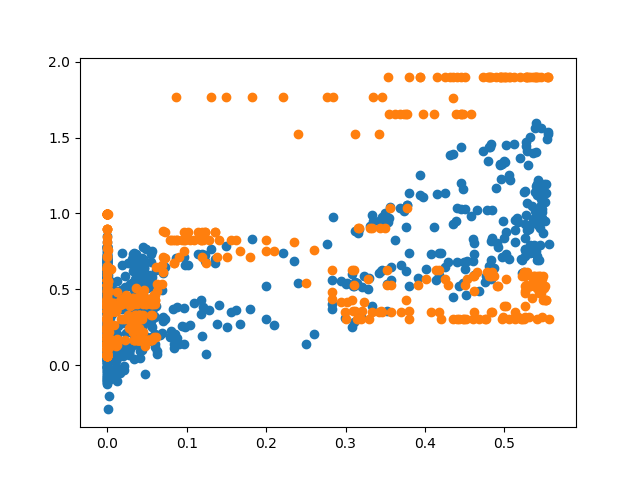

['wind_speed', 'Temp', 'VWC', 'Sedge', 'Out_of_Basin']
0.22391400501421024
0.5114123867311876


C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [378]:
fch4.Project(Projector = None,Model = None)
# fch4.Project(Projector = None,Model = None)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(fch4.RST.Data[fch4.params['Inputs']],fch4.RST.Data[fch4.params['target']])


y_pred = reg.predict(fch4.RST.Data[fch4.params['Inputs']])
print(metrics.mean_squared_error(y_pred,fch4.RST.Data[fch4.params['target']]))
print(metrics.r2_score(fch4.RST.Data[fch4.params['target']],y_pred))
y_pred2 =  reg.predict(fch4.RST.Data[fch4.params['Inputs']])
# reg.coef_

# reg.intercept_ 

# reg.predict(np.array([[3, 5]]))
             
# print()
fch4.RST.Data['y_pred2']=y_pred2
plt.figure()
Var = 'Sedge'
# Var = 'PPFD_Avg'
plt.scatter(fch4.RST.Data[Var],fch4.RST.Data['y_pred2'])


# import CART_Backend as Tree

# tree = Tree.Trees(fch4.RST.Data,'fch4',params['Inputs'])
# tree.Validate(kind='Tree',N_Max=15,step_size=1,ax=ax,iteration=15,min_samples_leaf=10)


from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)
print(fch4.params['Inputs'])
forest.fit(fch4.RST.Data[fch4.params['Inputs']],fch4.RST.Data[fch4.params['target']])

y_pred = forest.predict(fch4.RST.Data[fch4.params['Inputs']])
y_pred3=forest.predict(fch4.RST.Data[fch4.params['Inputs']])
fch4.RST.Data['y_pred3']=y_pred3
plt.scatter(fch4.RST.Data[Var],fch4.RST.Data['y_pred3'])
print(metrics.mean_squared_error(y_pred,fch4.RST.Data[fch4.params['target']]))
print(metrics.r2_score(fch4.RST.Data[fch4.params['target']],y_pred))

In [347]:
### Comparrisson

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression

# T30 = fco2.RST.Master.copy()
# T30['TA'] = T30['AirTC_Avg'].shift(-2)

# T30 = T30.loc[((T30.index>'2016-07-10 23:30:00') & (T30.index<'2016-08-07 00:00:00'))]
# T30['Rain_mm_Tot']=T30['Rain_mm_Tot'].fillna(0)*10
# T30[['Sedge','Shrub','Grass','Upland']]=T30[['Sedge','Shrub','Grass','Upland']].interpolate()
# forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)
# Vars = ['TA','AirTC_Avg','NR_Wm2_Max','wind_speed','Rain_mm_Tot','VPD','DOY','DOY2','Temp','VWC']
# test = T30.loc[T30['DOY']<200,Vars].dropna()
# Key = Vars[0:5]
# forest=LinearRegression().fit(test[Key],test['Temp'])
# T30[Key]=T30[Key].ffill().bfill()
# T30['TempFIll'] = forest.predict(T30[Key])
# test = T30[['TempFIll','Temp','AirTC_Avg']].dropna()
# # print(metrics.r2_score(test['Temp'],test['TempFIll']))
# T30['Temp']=T30['Temp'].fillna(T30['TempFIll'])
# test = T30[Vars].dropna()
# Key=['DOY','DOY2','Temp','Rain_mm_Tot']
# forest = LinearRegression().fit(test[Key],test['VWC'])
# T30[Key]=T30[Key].ffill().bfill()
# T30['TempFIll'] = forest.predict(T30[Key])
# test = T30[['TempFIll','VWC',]].dropna()
# # print(metrics.r2_score(test['VWC'],test['TempFIll']))
# T30['VWC']=T30['VWC'].fillna(T30['TempFIll'])

# Temp = T30[['NEE_JustPPFD','fco2']]
# Temp['T'] = Temp['fco2']*0
# Temp['T'] = Temp['T'].fillna(1)
# print(Temp['T'].sum()/Temp['T'].count())


# Temp = T30[['NEE_JustPPFD','fco2']].dropna()

# print(metrics.mean_squared_error(Temp['fco2'],Temp['NEE_JustPPFD'])**.5)
# Temp['fco2_temp'] = Temp['fco2'].fillna(Temp['NEE_JustPPFD'])
# print(Temp['fco2_temp'].mean(),Temp['fco2_temp'].std()/(Temp['fco2_temp'].count())**.5*stats.t.ppf(.05,Temp['fco2_temp'].count()))
                      
    
# print(Temp['NEE_JustPPFD'].mean(),Temp['NEE_JustPPFD'].std()/(Temp['NEE_JustPPFD'].count())**.5*stats.t.ppf(.05,
#                                                                                                    Temp['NEE_JustPPFD'].count()))

# T30['NEE'] = T30['fco2'].fillna(T30['NEE_est'])
# # T30['NEE'] = T30['fco2'].fillna(T30['NEE_est'])
# T30['NME'] = T30['fch4'].fillna(T30['NME_est'])


